In [1]:
import warnings
warnings.filterwarnings('ignore')
import inspect
import logging
import os

import pandas as pd

from csrank.util import setup_logging
from experiments.util import lp_metric_dict
import numpy as np
from experiments.dbconnection import DBConnector

Using TensorFlow backend.


In [2]:
DIR_PATH = os.path.dirname(os.path.abspath(inspect.getfile(inspect.currentframe())))
log_path = os.path.join(DIR_PATH, 'logs', 'results.log')
setup_logging(log_path=log_path)
logger = logging.getLogger('ResultParsing')
datasets = ['synthetic_dc', 'mnist_dc', 'tag_genome_dc', "letor_dc", "sushi_dc"]

In [3]:
def create_jobs_csv():
    config_file_path = os.path.join(DIR_PATH, 'config', 'clusterdb.json')
    learning_problem = "discrete_choice"
    results_table = 'results.{}'.format(learning_problem)
    start = 3
    schema = 'masterthesis'
    select_jobs = "SELECT * from {}.{}".format('{}', "avail_jobs")
    self = DBConnector(config_file_path=config_file_path, is_gpu=False, schema=schema)
    self.init_connection()
    #print(select_st)
    
    self.cursor_db.execute("select * from masterthesis.avail_jobs where job_id=1")
    columns = dict(self.cursor_db.fetchone()).keys()
    print(columns)
    self.init_connection()
    self.cursor_db.execute(select_jobs.format('masterthesis'))
    data = []
    for job in self.cursor_db.fetchall():
        job = dict(job)
        one_row = [job[key] for key in columns]
        data.append(one_row)
    self.init_connection()
    self.cursor_db.execute(select_jobs.format('pymc3'))
    for job in self.cursor_db.fetchall():
        job = dict(job)
        one_row = [job[key] for key in columns]
        data.append(one_row)
    self.close_connection()
    df = pd.DataFrame(data, columns=columns)
    df_path = os.path.join(DIR_PATH, 'jobs' , "job_configs.csv")
    df.to_csv(df_path)
create_jobs_csv()

dict_keys(['job_id', 'fold_id', 'dataset', 'learner', 'experiment_schema', 'experiment_table', 'dataset_params', 'fit_params', 'learner_params', 'hp_ranges', 'hp_fit_params', 'hp_iters', 'is_gpu', 'seed', 'inner_folds', 'duration', 'learning_problem', 'validation_loss', 'hash_value', 'job_allocated_time'])


In [4]:
def get_letor_string(dp):
    y =  str(dp['year']) 
    n = str(dp['n_objects'])
    return "y_{}_n_{}".format(y,n)
def get_results_for_dataset(DATASET, del_jid = True):
    config_file_path = os.path.join(DIR_PATH, 'config', 'clusterdb.json')
    learning_problem = "discrete_choice"
    results_table = 'results.{}'.format(learning_problem)
    schema = 'masterthesis'
    start = 3
    select_jobs = "SELECT learner_params, dataset_params, hp_ranges, {0}.job_id, dataset, learner, {3} from {0} INNER JOIN {1} ON {0}.job_id = {1}.job_id where {1}.dataset=\'{2}\'"
    self = DBConnector(config_file_path=config_file_path, is_gpu=False, schema=schema)
    keys = list(lp_metric_dict[learning_problem].keys())
    keys[-1] = keys[-1].format(6)
    metrics = ', '.join([x for x in keys])
    #print(metrics)
    
    self.init_connection()
    avail_jobs = "{}.avail_jobs".format(self.schema)
    select_st = select_jobs.format(results_table, avail_jobs, DATASET, metrics)
    #print(select_st)
    self.cursor_db.execute(select_st)
    data = []
    for job in self.cursor_db.fetchall():
        job = dict(job)
        n_hidden = job['hp_ranges'][job['learner']].get("n_hidden", [])
        if job['hp_ranges'][job['learner']].get("n_hidden_set_layers", None)==[1,8]:
            job['learner'] = job['learner']+'_shallow'
        elif n_hidden==[1,4] or n_hidden==[1,5]:
            job['learner'] = job['learner']+'_shallow'

        if job['learner_params'].get("add_zeroth_order_model", False):
            job['learner'] = job['learner']+'_zero'
        if "letor" in job['dataset']:
            job['dataset'] = get_letor_string(job['dataset_params'])
        elif "sushi" in job['dataset']:
            job['dataset'] =  job['dataset']
        else:
            job['dataset'] = job['dataset_params']['dataset_type']
        job['learner'] = job['learner'].upper()
        job['dataset'] = job['dataset'].upper()
        values = list(job.values())
        keys = list(job.keys())
        columns = keys[start:]
        vals = values[start:]
        data.append(vals)
    
    self.init_connection()
    avail_jobs = "{}.avail_jobs".format("pymc3")
    select_st = select_jobs.format(results_table, avail_jobs, DATASET, metrics)
    #print(select_st)
    self.cursor_db.execute(select_st)
    for job in self.cursor_db.fetchall():
        job = dict(job)
        if "letor" in job['dataset']:
            job['dataset'] = get_letor_string(job['dataset_params'])
        elif "sushi" in job['dataset']:
            job['dataset'] =  job['dataset']
        else:
            job['dataset'] = job['dataset_params']['dataset_type']
        job['learner'] = job['learner'].upper()
        job['dataset'] = job['dataset'].upper()
        values = list(job.values())
        keys = list(job.keys())
        columns = keys[start:]
        vals = values[start:]
        data.append(vals)
    df_full = pd.DataFrame(data, columns=columns)
    df_full = df_full.sort_values('dataset')
    if del_jid:
        del df_full['job_id']
    columns = list(df_full.columns)
    return df_full, columns

In [5]:
def get_max_min(maxi, mini, acc):
    if np.max(acc) > maxi:
        maxi = np.max(acc)
    if np.min(acc) < mini:
        mini = np.min(acc)
    return maxi, mini
def get_name(name):
    named = dict()
    named["NEAREST_NEIGHBOUR_MEDOID"] = "Nearest Neighbour"
    named["NEAREST_NEIGHBOUR"] = "Most Similar Movie"
    named["DISSIMILAR_NEAREST_NEIGHBOUR"] = "Most Dissimilar Movie"
    named["CRITIQUE_FIT_LESS"] = "Best Critique-Fit Movie d=-1"
    named["CRITIQUE_FIT_MORE"] = "Best Critique-Fit Movie d=+1"
    named["DISSIMILAR_CRITIQUE_LESS"] = "Impostor Critique-Fit Movie d=-1"
    named["DISSIMILAR_CRITIQUE_MORE"] = "Impostor Critique-Fit Movie d=+1"
    named["UNIQUE_MAX_OCCURRING"] = "Mode Least Angle"
    named["SUSHI_DC"] = "SUSHI"
    named["Y_2007_N_10"] = "MQ2007 10 Objects"
    named["Y_2007_N_5"] = "MQ2007 5 Objects"
    named["Y_2008_N_10"] = "MQ2008 10 Objects"
    named["Y_2008_N_5"] = "MQ2008 5 Objects"
    if name not in named.keys():
        named[name] = name.lower().title()
    return named[name]
def create_combined_dfs(DATASET):
    df_full, cols = get_results_for_dataset(DATASET)
    data = []
    dataf = []
    columns = []
    for c in cols:
        if 'categorical' in c:
            columns.append("{}se".format(c))
    columns = cols + columns
    for dataset, dgroup in df_full.groupby(['dataset']):
        max_feta = -100
        max_fate = -100
        max_ranknet = -100
        feta_r = []
        fate_r = []
        ranknet_r = []
        for learner, group in dgroup.groupby(['learner']):
            one_row = [dataset, learner]
            std = np.around(group.std(axis=0).values,3)
            mean = np.around(group.mean(axis=0).values,3)
            if np.all(np.isnan(std)):
                one_row.extend(["{:.4f}".format(m) for m in mean])
                #latex_row.extend(["${:.3f}$".format(m) for m in mean]) 
            else:
                std_err = [s for s in std]
                #std_err = [s/np.sqrt(len(group)) for s in std]
                one_row.extend([m for m in mean])
                one_row.extend([se for se in std_err])
                #one_row.extend(mean)
                #latex_row.extend(["$ {:.3f} \pm {:.3f} ".format(m, s) for m, s in zip(mean, std)])
            if "FETA" in str(learner):
                if max_feta < mean[0] - std[0]:
                    max_feta = mean[0] - std[0]
                    feta_r = one_row
                    feta_r[1] = "FETA_DC"
            elif "FATE" in str(learner):
                if max_feta < mean[0] - std[0]:
                    max_fate = mean[0] - std[0]
                    fate_r = one_row
                    fate_r[1] = "FATE_DC"
            elif "RANKNET" in str(learner):
                if max_ranknet < mean[0] - std[0]:
                    max_ranknet = mean[0] - std[0]
                    ranknet_r = one_row
                    ranknet_r[1] = "RANKNET_DC"
            else:
                data.append(one_row)
        data.append(feta_r)
        data.append(ranknet_r)
        data.append(fate_r)
    df = pd.DataFrame(data, columns=columns)
    df.sort_values(by='dataset')
    del df['categoricaltopk6']
    del df['categoricaltopk6se']
    return df
df = create_combined_dfs(datasets[0])
df.head()

,dataset,learner,categoricalaccuracy,categoricaltopk2,categoricaltopk3,categoricaltopk4,categoricaltopk5,categoricalaccuracyse,categoricaltopk2se,categoricaltopk3se,categoricaltopk4se,categoricaltopk5se
0,HYPERVOLUME,GENERALIZED_EXTREME_VALUE,0.293,0.369,0.472,0.567,0.663,0.018,0.020,0.021,0.018,0.014
1,HYPERVOLUME,MIXED_LOGIT_MODEL,0.189,0.338,0.451,0.542,0.621,0.014,0.017,0.019,0.020,0.014
2,HYPERVOLUME,MULTINOMIAL_LOGIT_MODEL,0.201,0.267,0.360,0.456,0.559,0.008,0.010,0.010,0.008,0.004
3,HYPERVOLUME,NESTED_LOGIT_MODEL,0.291,0.416,0.511,0.582,0.651,0.003,0.005,0.007,0.006,0.006
4,HYPERVOLUME,PAIRED_COMBINATORIAL_LOGIT,0.185,0.248,0.340,0.440,0.550,0.001,0.001,0.002,0.002,0.002


In [6]:
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set(color_codes=True)
plt.style.use('default')
def plot_group(grouped, plot_file, size, cols, a, b, maxi, mini, sharey=False, sharex = False, zoom=False):
    fig, axs = plt.subplots(a, b, figsize=size, sharey=sharey, sharex=sharex ,frameon=True, edgecolor='k', facecolor='white')
    fig.tight_layout() # Or equivalently,  "plt.tight_layout()"
    fig.subplots_adjust(hspace=0)
    markers = ['o', '^', 'v', 'x', "*", '.', "+", "d","P"]
    n_objects = 10
    for i, group in enumerate(grouped):
        zmini = 100
        zmaxi = -100
        name, group = group[0], group[1]
        if "N_5" in name:
            del group['categoricaltopk5']
            del group['categoricaltopk5se']
            n_objects = 5
        N_OBJECTS_ARRAY = np.arange(len(group.columns[2:])/2) + 1
        total = len(N_OBJECTS_ARRAY)
        dataFrame = group.set_index('learner').T
        try:
            if zoom:
                sub_plot, sub_plotz = axs[i][0], axs[i][1]
            else:
                sub_plot = axs[i]
        except Exception:
            if zoom:
                sub_plot, sub_plotz = axs
            else:
                sub_plot = axs
        j = 0
        for learner, model in zip(Dlower,models):
            if learner in list(dataFrame.columns):
                acc_se = dataFrame[learner].as_matrix()[1:]
                acc = acc_se[0:total]
                se = acc_se[total:]
                zmaxi, zmini = get_max_min(zmaxi, zmini, acc[0:2])
                sub_plot.errorbar(N_OBJECTS_ARRAY, acc, se, label=model, marker=markers[j], linewidth=1)
                if zoom:
                    sub_plotz.plot(N_OBJECTS_ARRAY[0:2], acc[0:2], label=model, marker=markers[j], linewidth=1)
                j = j+1
        
        acc = N_OBJECTS_ARRAY/n_objects
        sub_plot.plot(N_OBJECTS_ARRAY, acc, label='RANDOM', linewidth=1, color='k', marker='H')
        #zmaxi, zmini = get_max_min(zmaxi, zmini, acc[0:2])
        if i == 0:
            sub_plot.set_ylabel(y_label)
            maxi, mini = get_max_min(maxi, mini, acc)
        sub_plot.set_yticks(np.arange(mini, maxi+0.1, 0.05))
        sub_plot.set_xticks(N_OBJECTS_ARRAY)
        sub_plot.set_xlabel(x_label)
        if zoom:
            #sub_plotz.plot(N_OBJECTS_ARRAY[0:2], acc[0:2], label='RANDOM', linewidth=1, color='k', marker='H')
            sub_plotz.set_xticks(N_OBJECTS_ARRAY[0:2])
            sub_plotz.set_yticks(np.arange(zmini, zmaxi, 0.1))
            sub_plotz.set_xlabel(x_label)
            title = "{} {}".format("Zoomed in ",get_name(name))
            sub_plotz.set_title(title, horizontalalignment='center', verticalalignment='bottom')
        title = "{} {}".format(anotation[i],get_name(name))
        sub_plot.set_title(title, horizontalalignment='center', verticalalignment='bottom')
    
    plt.legend(ncol=cols, fancybox=False, shadow=False, frameon=True, facecolor='white', edgecolor='k')
    fig_param['fname'] = plot_file
    plt.savefig(**fig_param)
    plt.tight_layout()
    plt.show()
def plot_graphs_for_dataset(DATASET):
    #plot_file = os.path.join(DIR_PATH, "detailedresults",'graphs', "{}{}.pdf".format(DATASET.split('_dc')[0], '{}'))
    plot_file = os.path.join(DIR_PATH, "thesis", "{}{}.pdf".format(DATASET.split('_dc')[0], '{}'))
    df = create_combined_dfs(DATASET)
    grouped = df.groupby(['dataset'])
    last = int(len(df.columns[2:])/2)
    maxi = np.around(np.max(df.as_matrix()[:,2:last+2]),2)
    mini = np.around(np.min(df.as_matrix()[:,2:last+2]),2)

    i = 0
    if len(grouped)in [4]:
        a = 1
        b = 2
        size = (15,6)
    if len(grouped) in [3,6]:
        a = 1
        b = 3
        size = (18,6)
    if len(grouped)==1:
        a = 1
        b = 1
        size = (8,6)
    ns = int(len(grouped)/b)

    if ns == 1:
        ns = len(grouped)
        plot_files = [plot_file.format('')]
    else:
        plot_files = [plot_file.format('_'+str(i)) for i in range(ns)]
        print
    sharex = False
    sharey = False
    margin=0.05
    groups = np.array([group for group in grouped])
    dict_inds = {'synthetic_dc':  [[1,2,0]], 'mnist_dc': [[0,1], [2,3]], 'tag_genome_dc':[[0,1, 5], [2,3, 4]], 
                 'letor_dc': [[1,3], [0,2]], 'sushi_dc':  [[0]]}
    #inds = 
    zoom = False
    inds = dict_inds[DATASET]
    for i, plot_file in enumerate(plot_files):
        if i == 0:
            cols = 3
        else:
            cols = 3
        if DATASET =='letor_dc':
            #sharex = True
            a = 2
            b = 2
            size = (15,12)
            zoom = True
        if DATASET =='sushi_dc':
            #sharex = True
            a = 1
            b = 2
            size = (15,6)
            zoom = True
        plot_group(groups[inds[i]], plot_file, size, cols, a, b, maxi, mini, sharey, sharex, zoom)

synthetic_dc


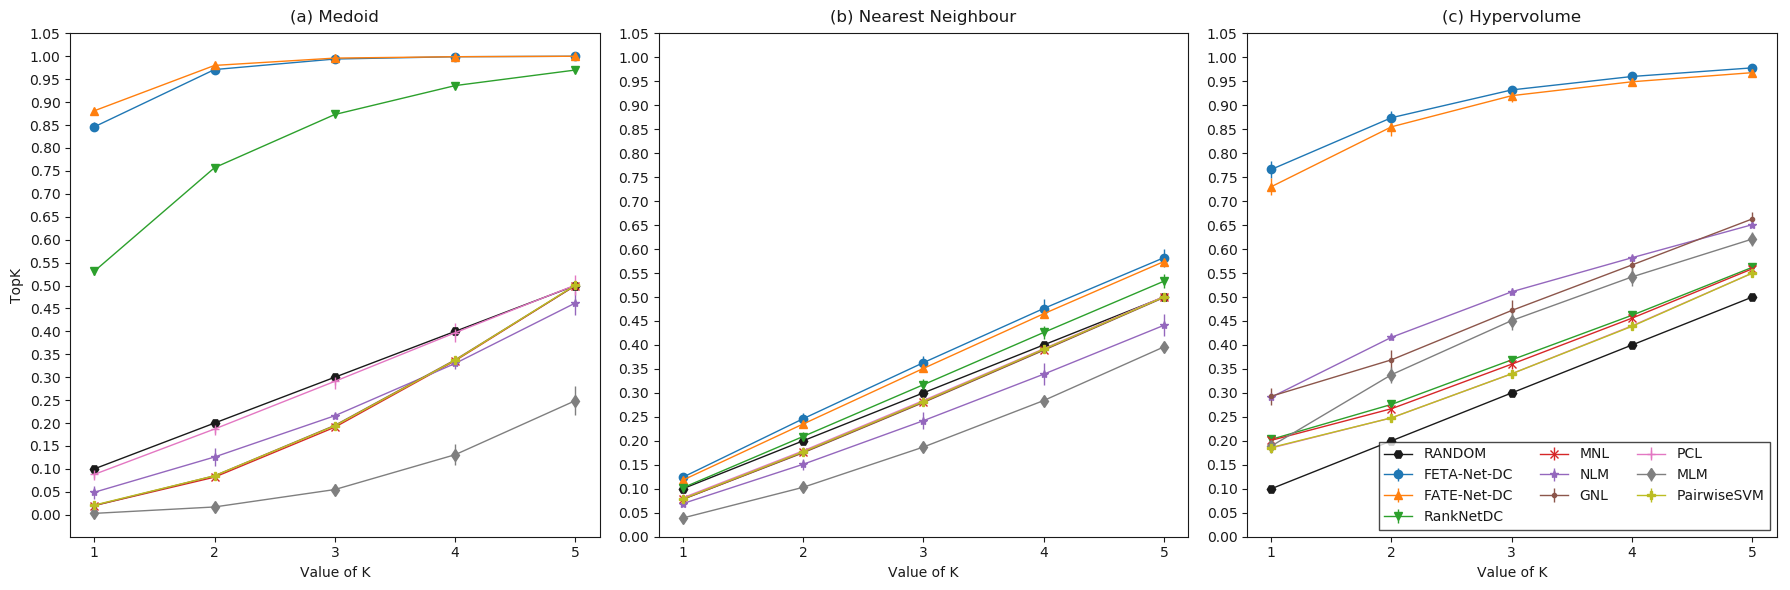

mnist_dc


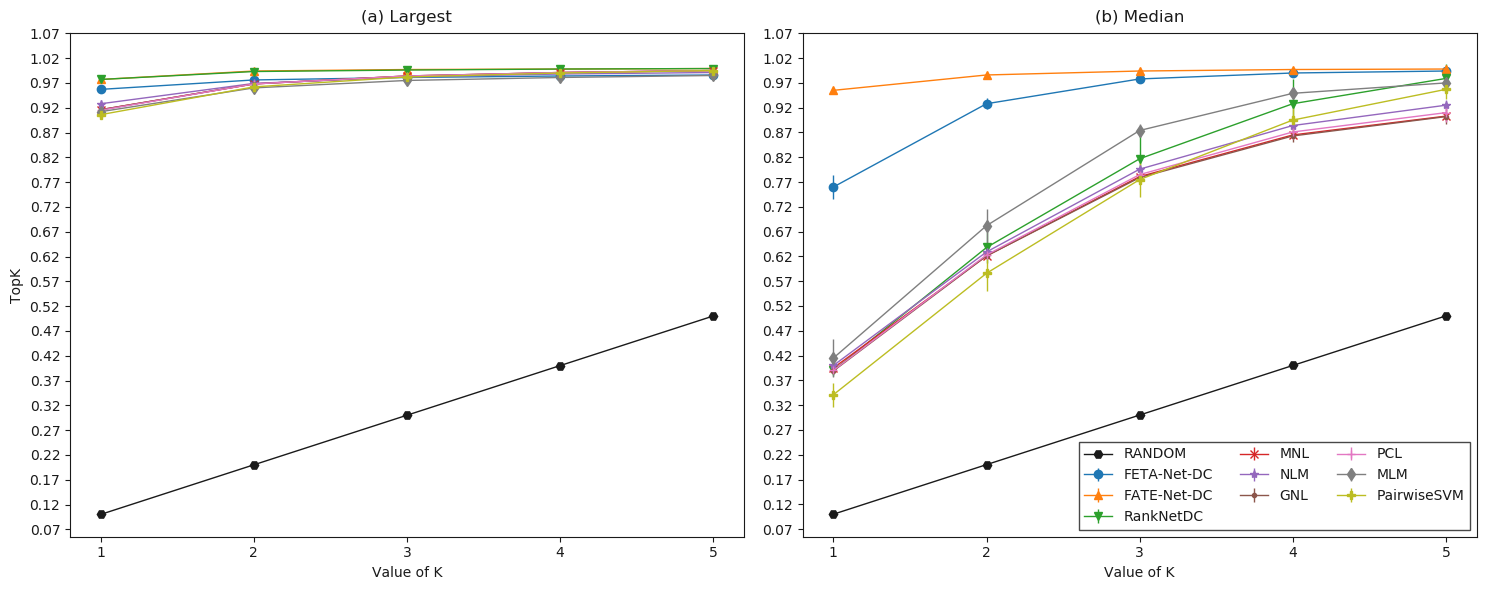

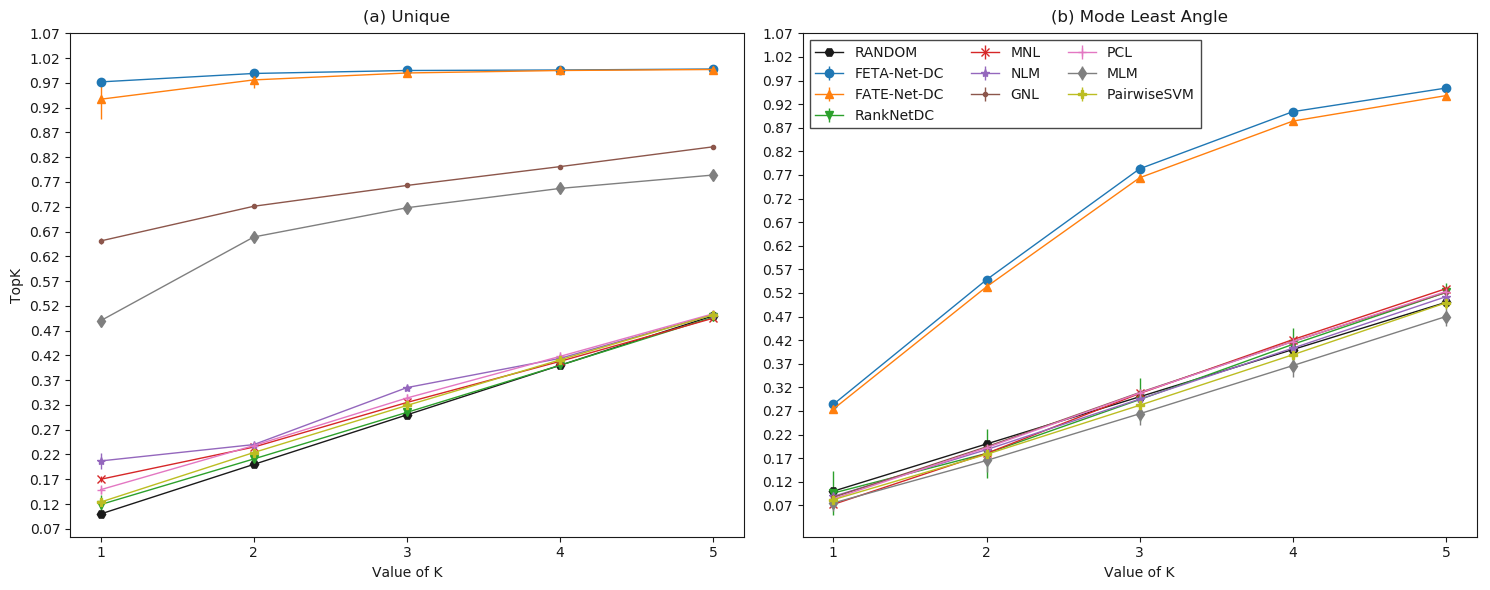

tag_genome_dc


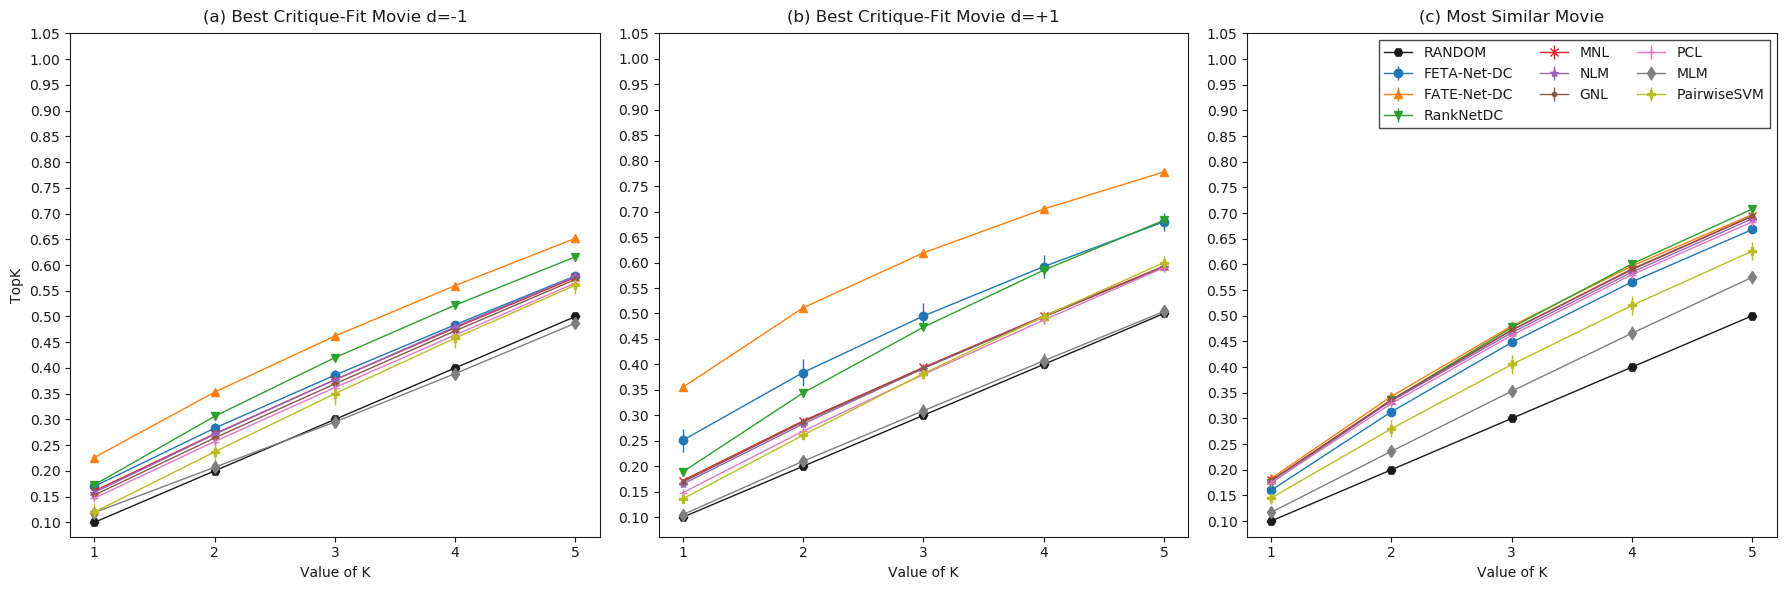

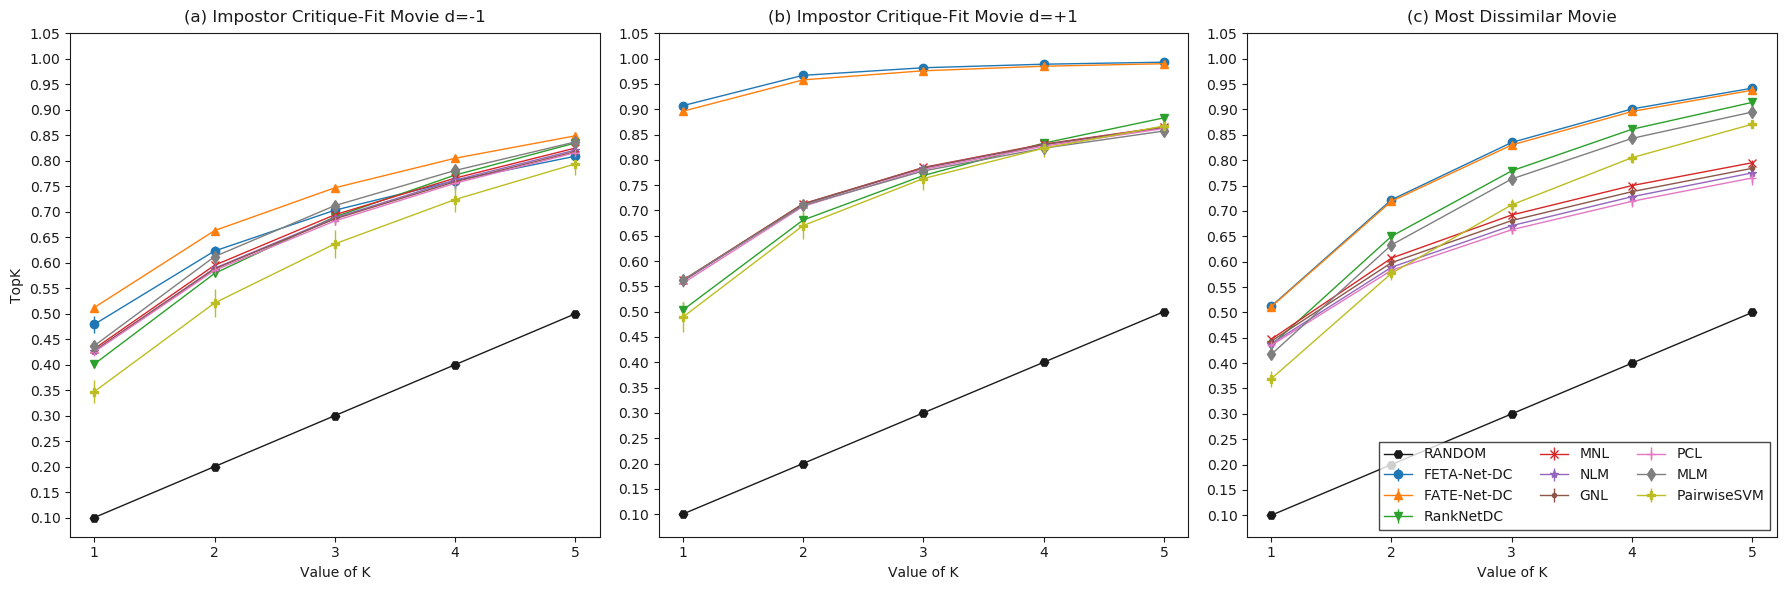

letor_dc


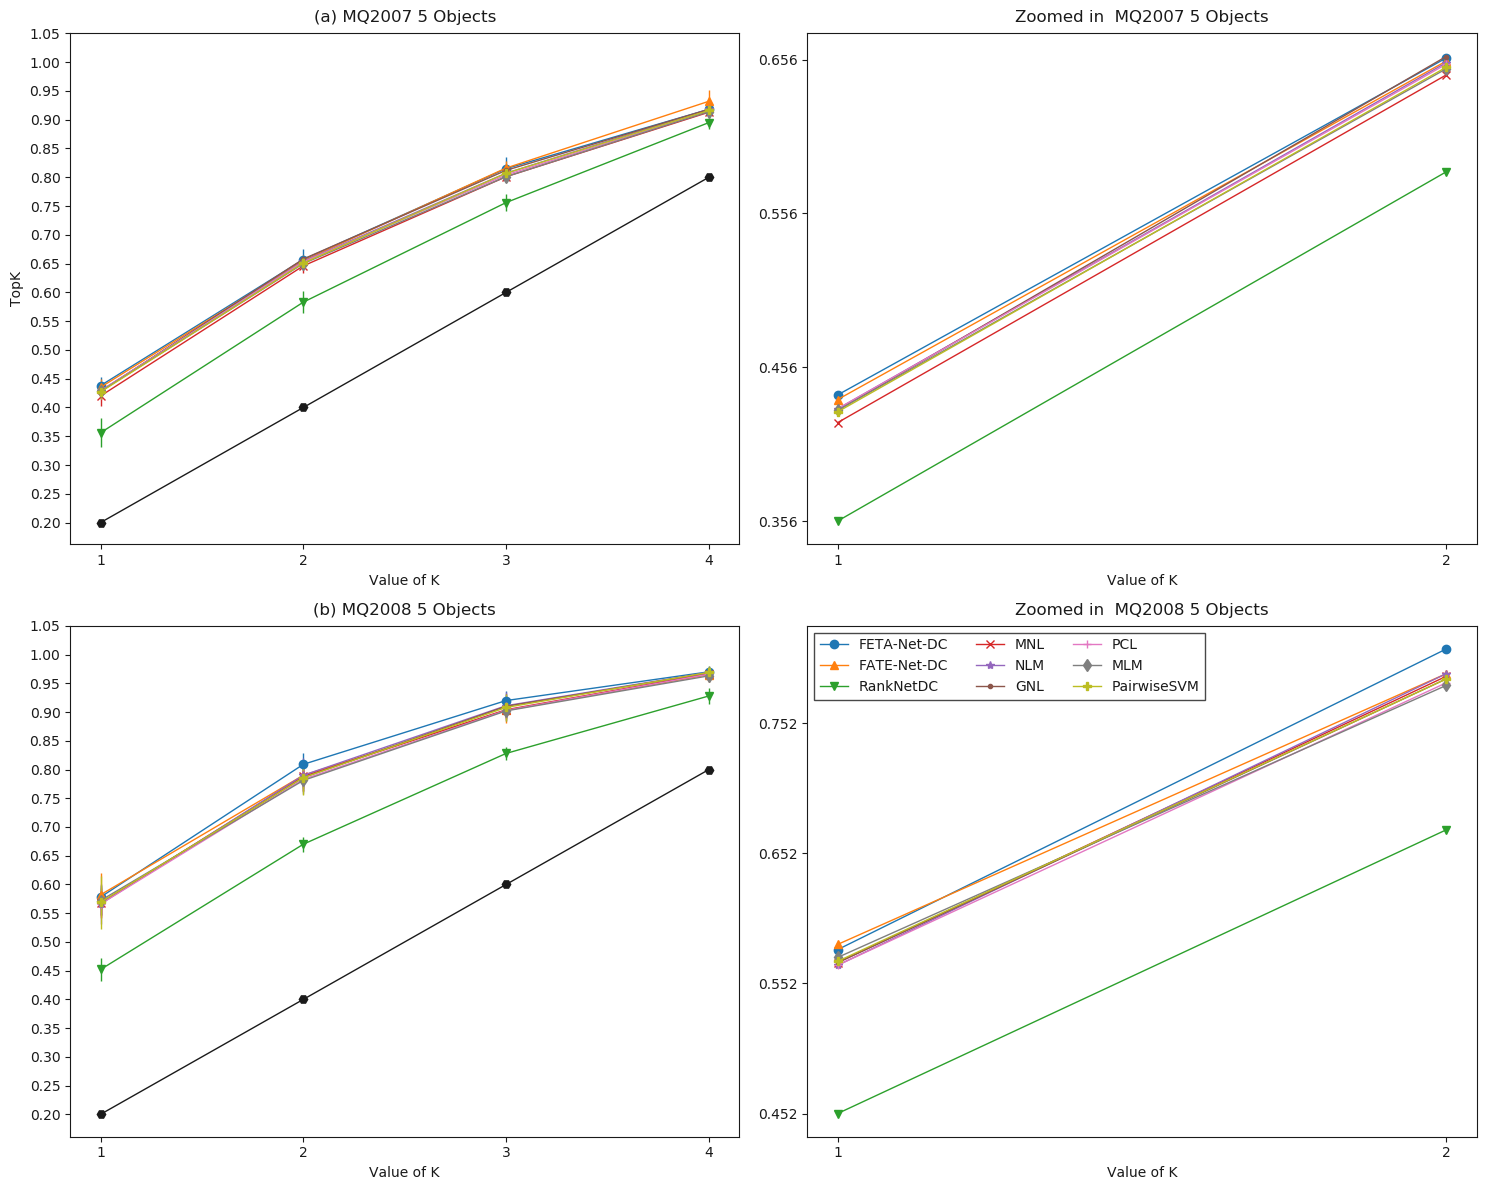

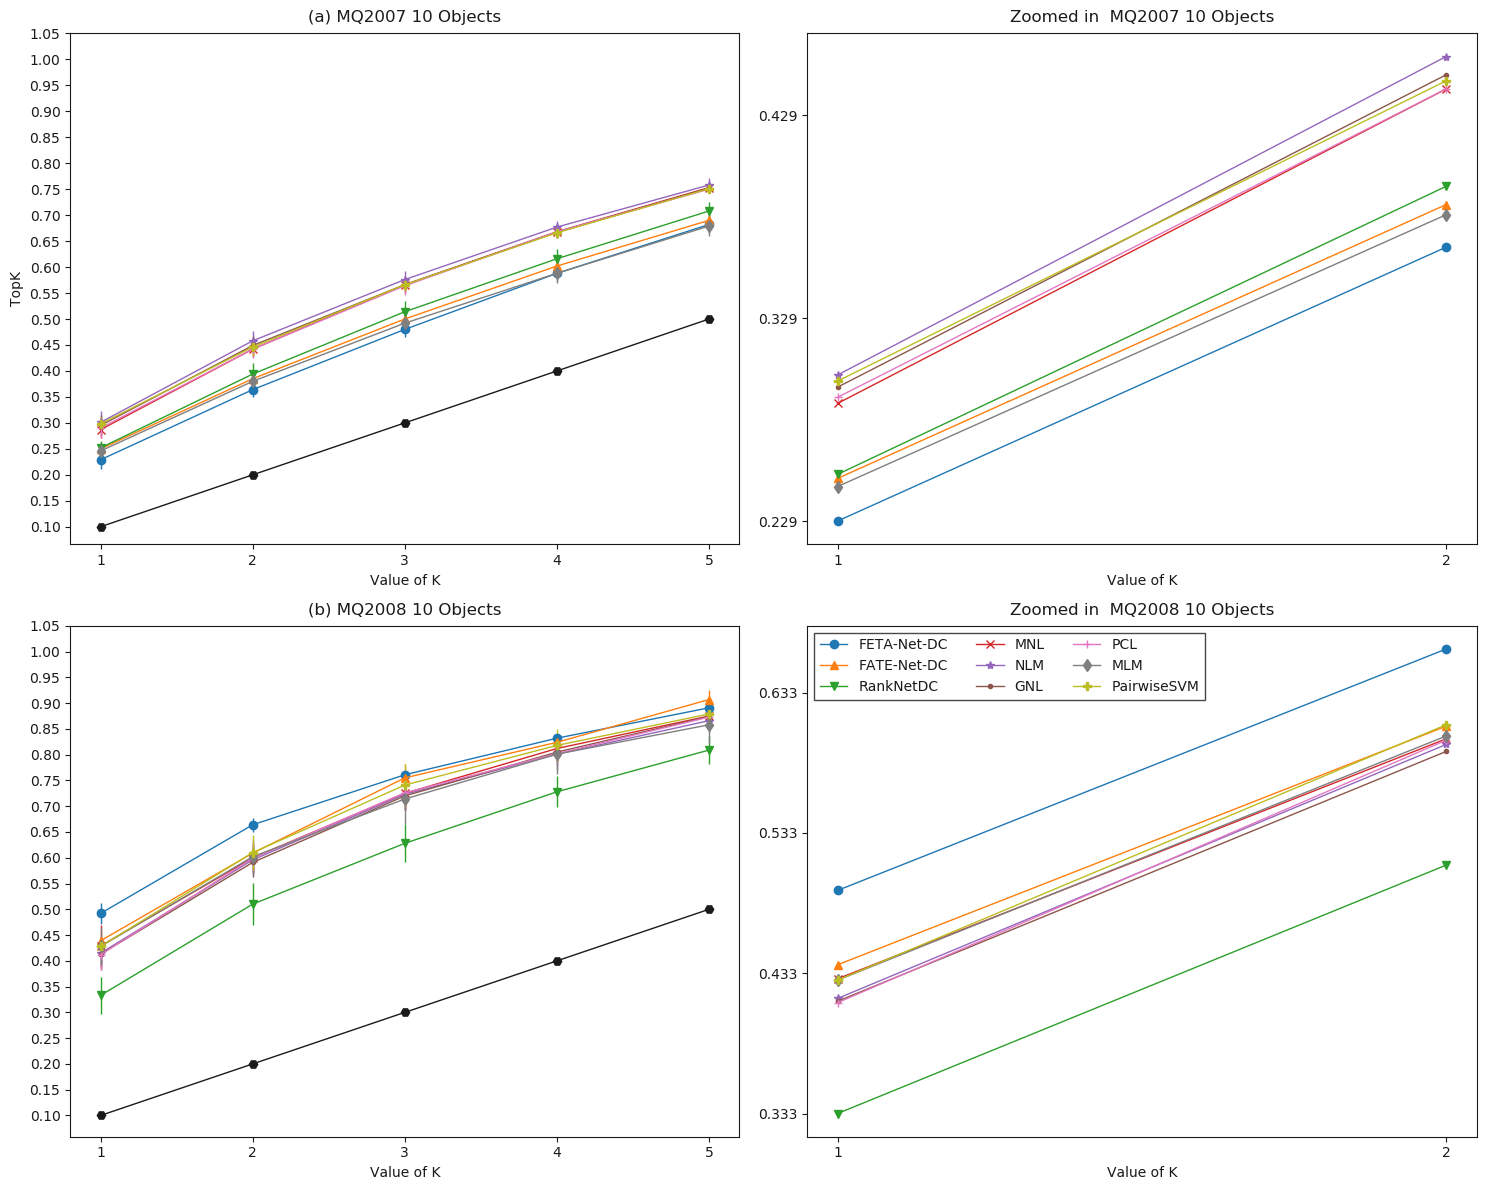

sushi_dc


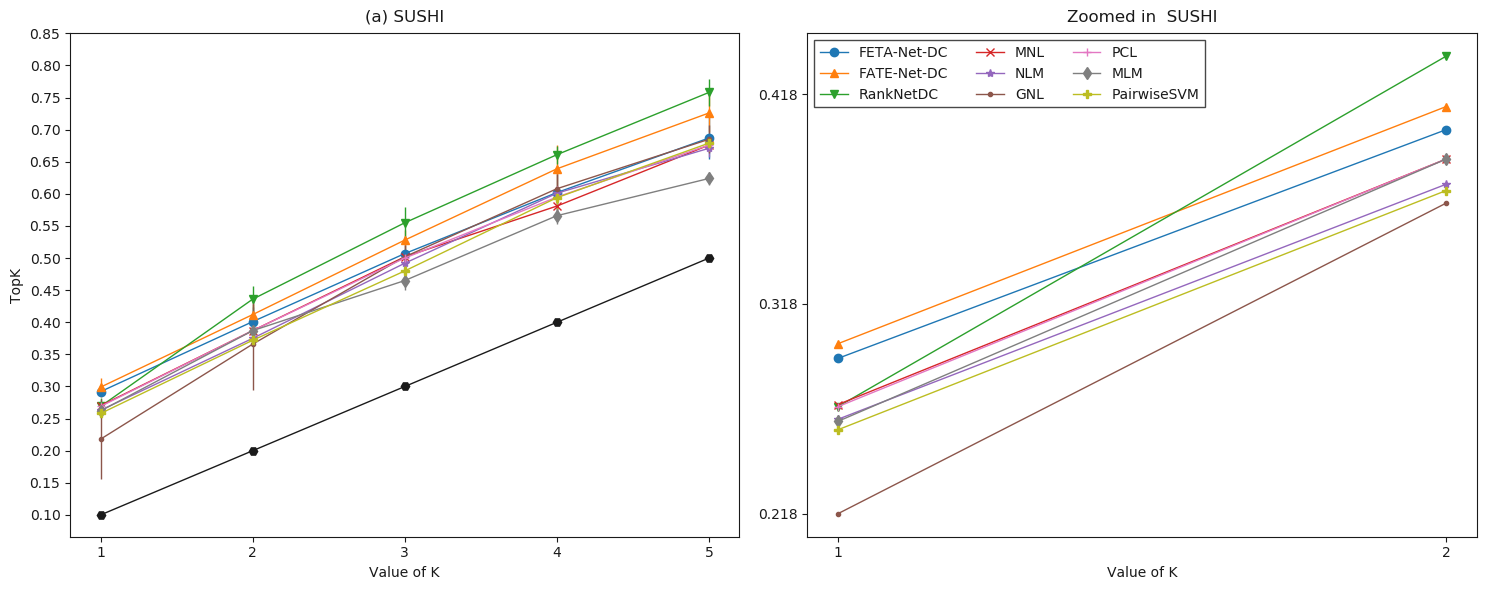

In [7]:
from constants import DCMS
models = ['FETA-Net-DC', 'FATE-Net-DC', 'RankNetDC', 'MNL', 'NLM', 'GNL', 'PCL', 'MLM', 'PairwiseSVM']
Dlower = [d.upper() for d in DCMS]
models_dict = dict(zip(Dlower, models))
y_label="TopK"
x_label="Value of K"
fig_param = {'facecolor':'w', 'edgecolor':'w', 'transparent':False, 'dpi':800, 'format':'pdf','bbox_inches':'tight', 'pad_inches':0.05}
anotation = ['(a)', '(b)','(c)','(d)','(e)','(f)','(g)']
for dataset in datasets:
    print(dataset)
    plot_graphs_for_dataset(dataset)

In [8]:
def create_combined_dfs2(DATASET, latex_row=False):
    df_full, columns = get_results_for_dataset(DATASET)
    data = []
    dataf = []
    for dataset, dgroup in df_full.groupby(['dataset']):
        max_feta = -100
        max_fate = -100
        max_ranknet = -100
        feta_r = []
        fate_r = []
        ranknet_r = []
        for learner, group in dgroup.groupby(['learner']):
            one_row = [get_name(dataset), learner]
            std = np.around(group.std(axis=0).values,3)
            mean = np.around(group.mean(axis=0).values,3)
            if np.all(np.isnan(std)):
                one_row.extend(["{:.4f}".format(m) for m in mean])
                #latex_row.extend(["${:.3f}$".format(m) for m in mean]) 
            else:
                std_err = [s for s in std]
                #std_err = [s/np.sqrt(len(group)) for s in std]
                #one_row.extend([m for m in mean])
                #one_row.extend([se for se in std_err])
                #one_row.extend(mean)
                if latex_row:
                    one_row.extend(["{:.3f}({:.0f})".format(m, s*1e3) for m, s in zip(mean, std)])
                else:
                    one_row.extend(["{:.3f}±{:.3f}".format(m, s) for m, s in zip(mean, std)])
            if "FETA" in str(learner):
                if max_feta < mean[0] - std[0]:
                    max_feta = mean[0] - std[0]
                    feta_r = one_row
                    feta_r[1] = models_dict["FETA_DC"]
            elif "FATE" in str(learner):
                if max_feta < mean[0] - std[0]:
                    max_fate = mean[0] - std[0]
                    fate_r = one_row
                    fate_r[1] = models_dict["FATE_DC"]
            elif "RANKNET" in str(learner):
                if max_ranknet < mean[0] - std[0]:
                    max_ranknet = mean[0] - std[0]
                    ranknet_r = one_row
                    ranknet_r[1] = models_dict["RANKNET_DC"]
            else:
                one_row[1] = models_dict[one_row[1]]
                data.append(one_row)
        data.append(feta_r)
        data.append(ranknet_r)
        data.append(fate_r)
    for i in range(len(columns)):
        if "categorical" in columns[i]:
            if "accuracy" in columns[i]:
                columns[i] = "CategoricalAccuracy"
            else:
                columns[i] = "Top-{}".format(columns[i].split("topk")[-1])
        else:
            columns[i] = columns[i].title()
            if columns[i] == 'Learner':
                columns[i] = "DCM"
    df = pd.DataFrame(data, columns=columns)
    df.sort_values(by='Dataset')
    return df

In [9]:
for dataset in datasets:
    df = create_combined_dfs2(dataset)
    df_path = os.path.join(DIR_PATH, 'detailedresults' , dataset.split('_dc')[0].title()+'.csv')
    df.to_csv(df_path, index=False, encoding='utf-8')
df

,Dataset,DCM,CategoricalAccuracy,Top-2,Top-3,Top-4,Top-5,Top-6
0,SUSHI,GNL,0.218±0.062,0.366±0.071,0.502±0.018,0.608±0.023,0.685±0.022,0.754±0.034
1,SUSHI,MLM,0.262±0.007,0.387±0.008,0.465±0.014,0.566±0.013,0.624±0.010,0.724±0.014
2,SUSHI,MNL,0.270±0.006,0.387±0.005,0.502±0.002,0.581±0.018,0.676±0.011,0.786±0.007
3,SUSHI,NLM,0.263±0.012,0.375±0.005,0.492±0.014,0.601±0.011,0.671±0.013,0.736±0.024
4,SUSHI,PCL,0.269±0.006,0.387±0.006,0.500±0.012,0.595±0.018,0.676±0.010,0.785±0.006
5,SUSHI,PairwiseSVM,0.258±0.004,0.372±0.007,0.480±0.022,0.594±0.017,0.679±0.013,0.779±0.006
6,SUSHI,FETA-Net-DC,0.292±0.007,0.401±0.023,0.507±0.026,0.602±0.040,0.687±0.032,0.769±0.035
7,SUSHI,RankNetDC,0.269±0.013,0.436±0.020,0.555±0.025,0.661±0.014,0.758±0.021,0.831±0.020
8,SUSHI,FATE-Net-DC,0.299±0.015,0.412±0.016,0.528±0.016,0.639±0.037,0.726±0.030,0.805±0.008


In [14]:
def plot_graphs_for_dataset(DATASET):
    #plot_file = os.path.join(DIR_PATH, "detailedresults",'graphs', "{}{}.pdf".format(DATASET.split('_dc')[0], '{}'))
    plot_file = os.path.join(DIR_PATH, "presentation", "{}{}.png".format(DATASET.split('_dc')[0], '{}'))
    df = create_combined_dfs(DATASET)
    if DATASET == 'synthetic_dc':
        df = df[df['dataset'] != "NEAREST_NEIGHBOUR_MEDOID"]

    grouped = df.groupby(['dataset'])
    last = int(len(df.columns[2:])/2)
    maxi = np.around(np.max(df.as_matrix()[:,2:last+2]),2)
    mini = np.around(np.min(df.as_matrix()[:,2:last+2]),2)
    i = 0
    if len(grouped)in [2, 4]:
        a = 1
        b = 2
        size = (15,6)
    if len(grouped) in [3,6]:
        a = 1
        b = 3
        size = (18,6)
    if len(grouped)==1:
        a = 1
        b = 1
        size = (8,6)
    ns = int(len(grouped)/b)

    if ns == 1:
        ns = len(grouped)
        plot_files = [plot_file.format('')]
    else:
        plot_files = [plot_file.format('_'+str(i)) for i in range(ns)]
    sharex = False
    sharey = False
    margin=0.05
    groups = np.array([group for group in grouped])
    dict_inds = {'synthetic_dc':  [[1,0]], 'mnist_dc': [[0,1], [2,3]], 'tag_genome_dc':[[0,1, 5], [2,3, 4]], 
                 'letor_dc': [[1,3], [0,2]], 'sushi_dc':  [[0]]}
    #inds = 
    zoom = False
    inds = dict_inds[DATASET]
    for i, plot_file in enumerate(plot_files):
        if i == 0:
            cols = 3
        else:
            cols = 3
        #if DATASET =='letor_dc':
            #sharex = True
        #    a = 2
        #    b = 2
        #    size = (15,12)
        #    zoom = True
        if DATASET =='sushi_dc':
            #sharex = True
            a = 1
            b = 2
            size = (15,6)
            zoom = True
        plot_group(groups[inds[i]], plot_file, size, cols, a, b, maxi, mini, sharey, sharex, zoom)

synthetic_dc


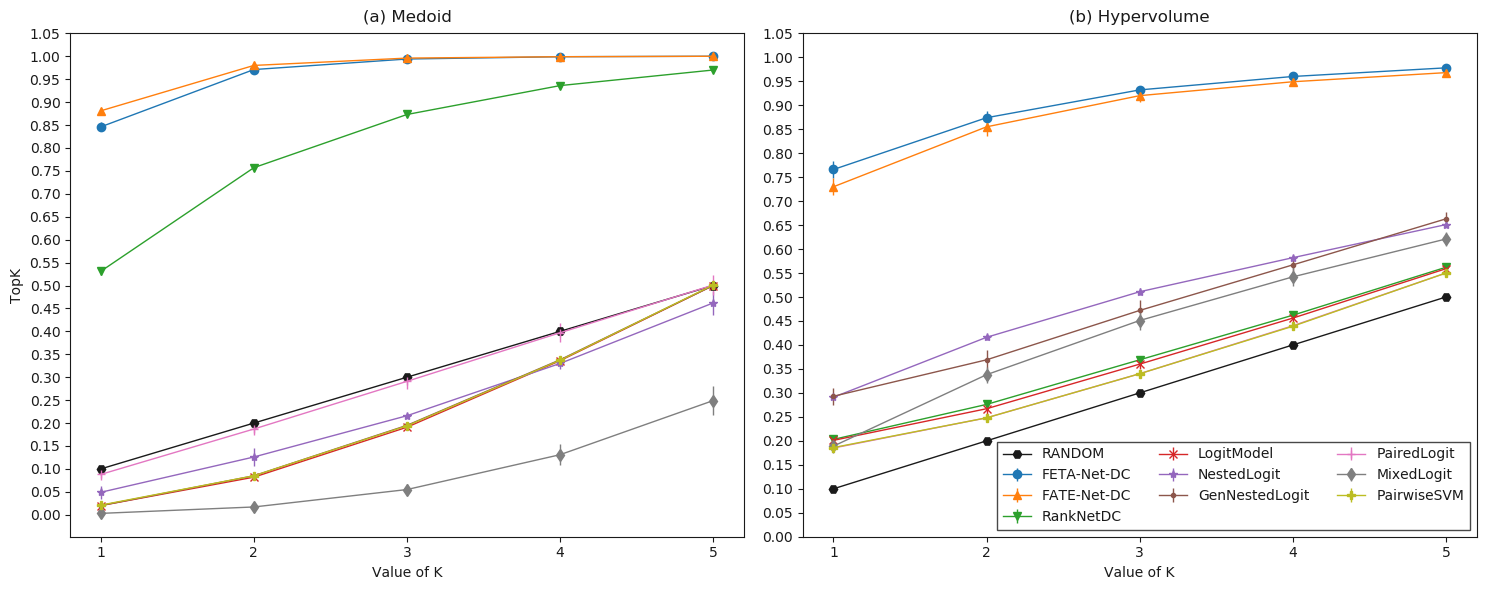

mnist_dc


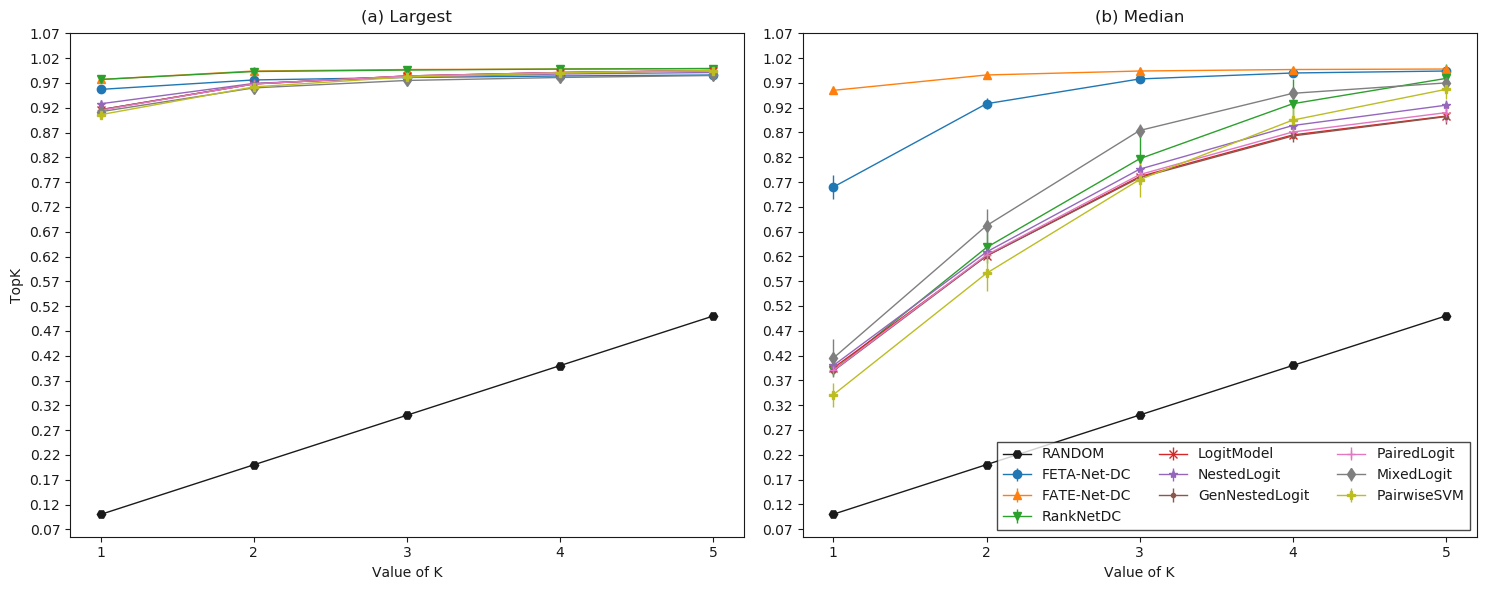

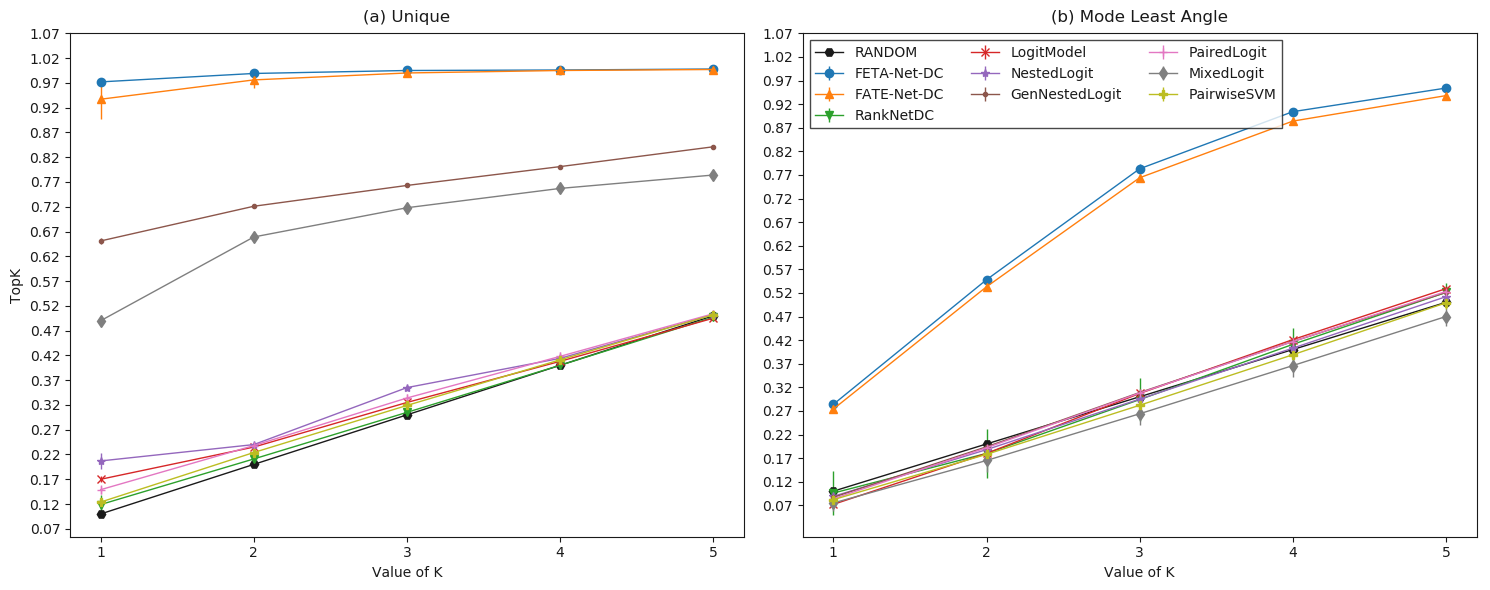

tag_genome_dc


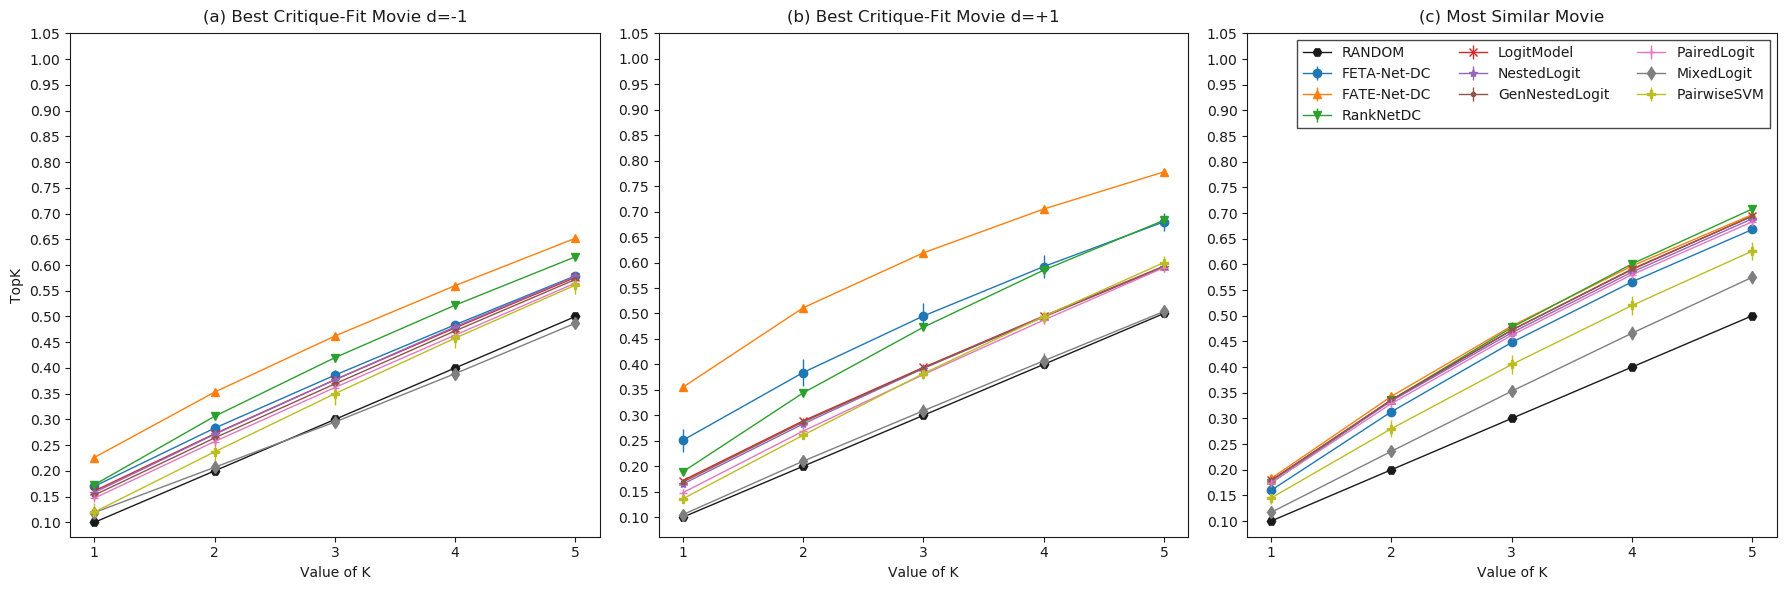

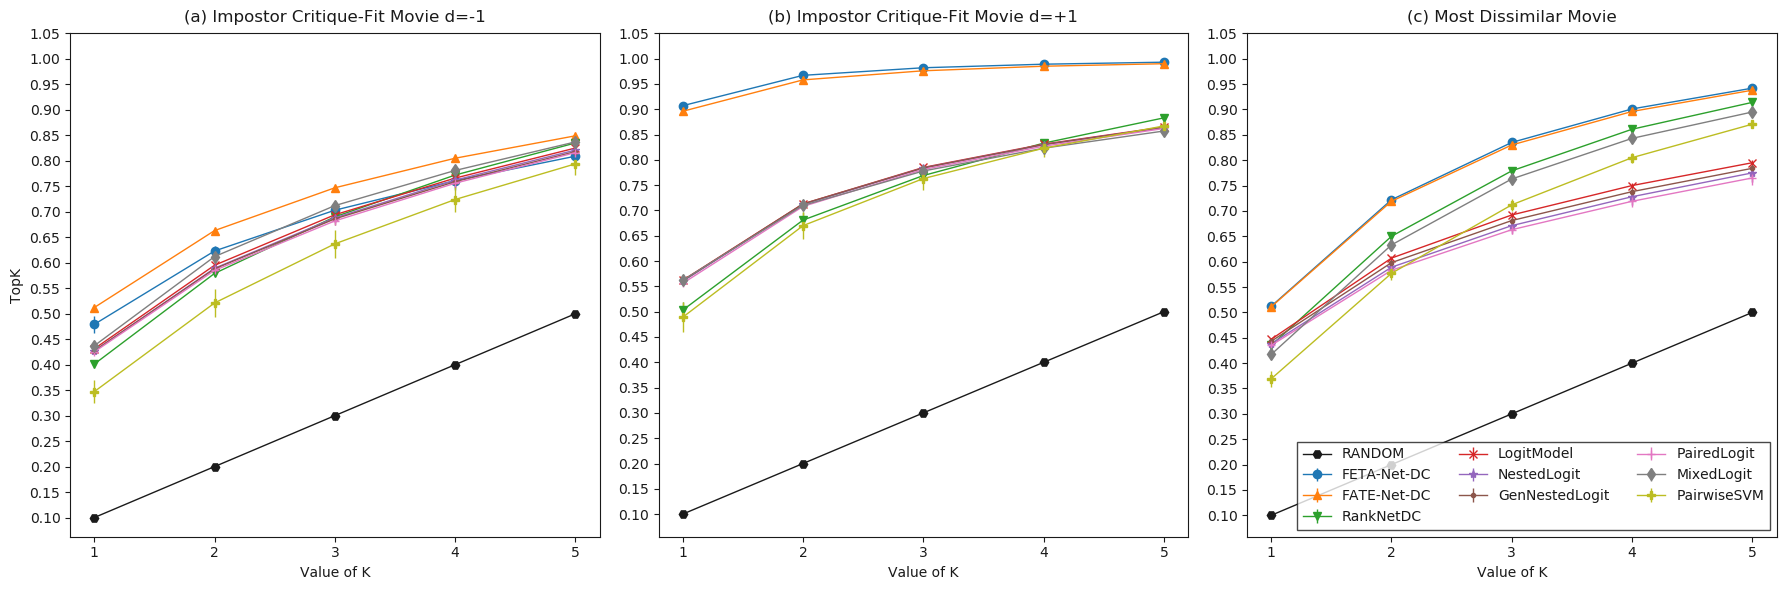

letor_dc


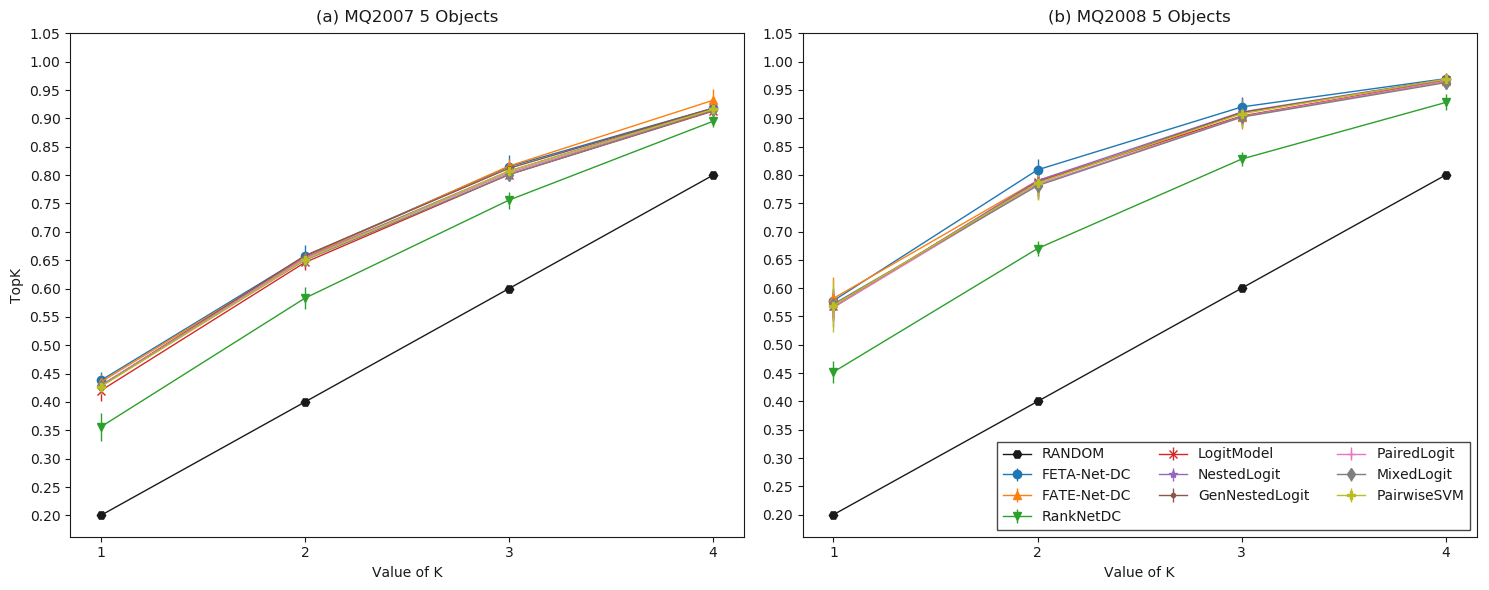

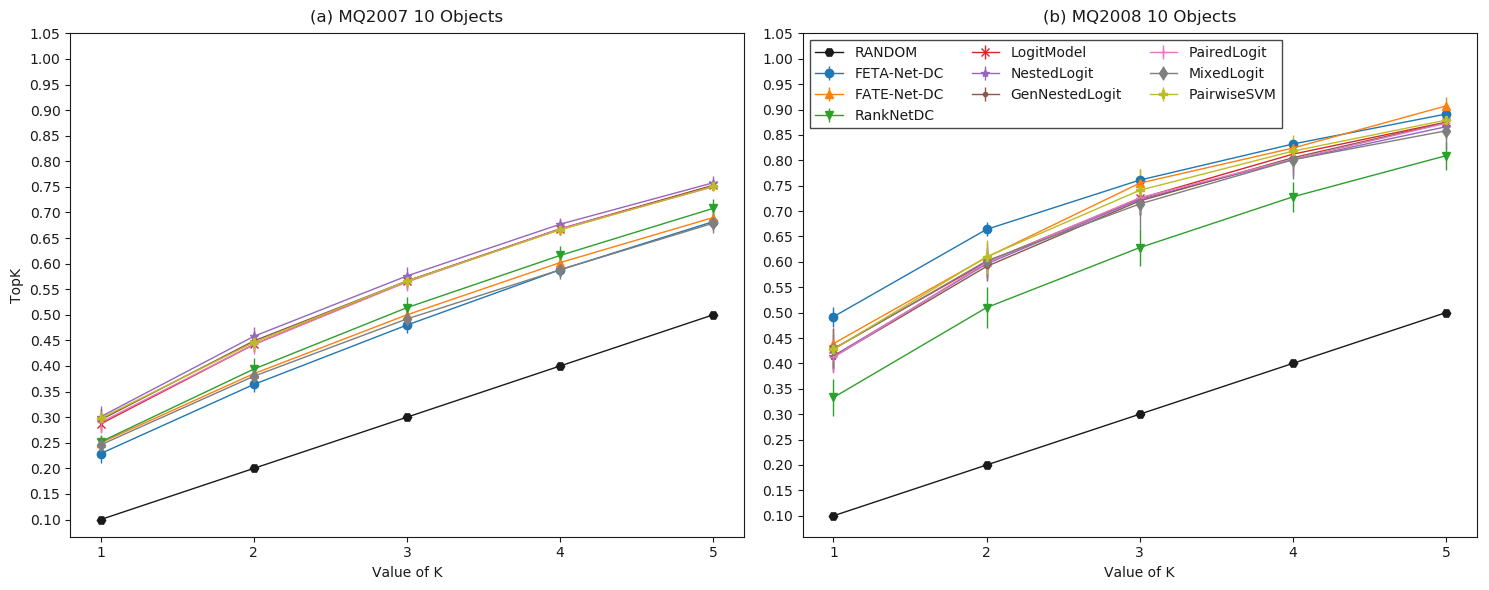

sushi_dc


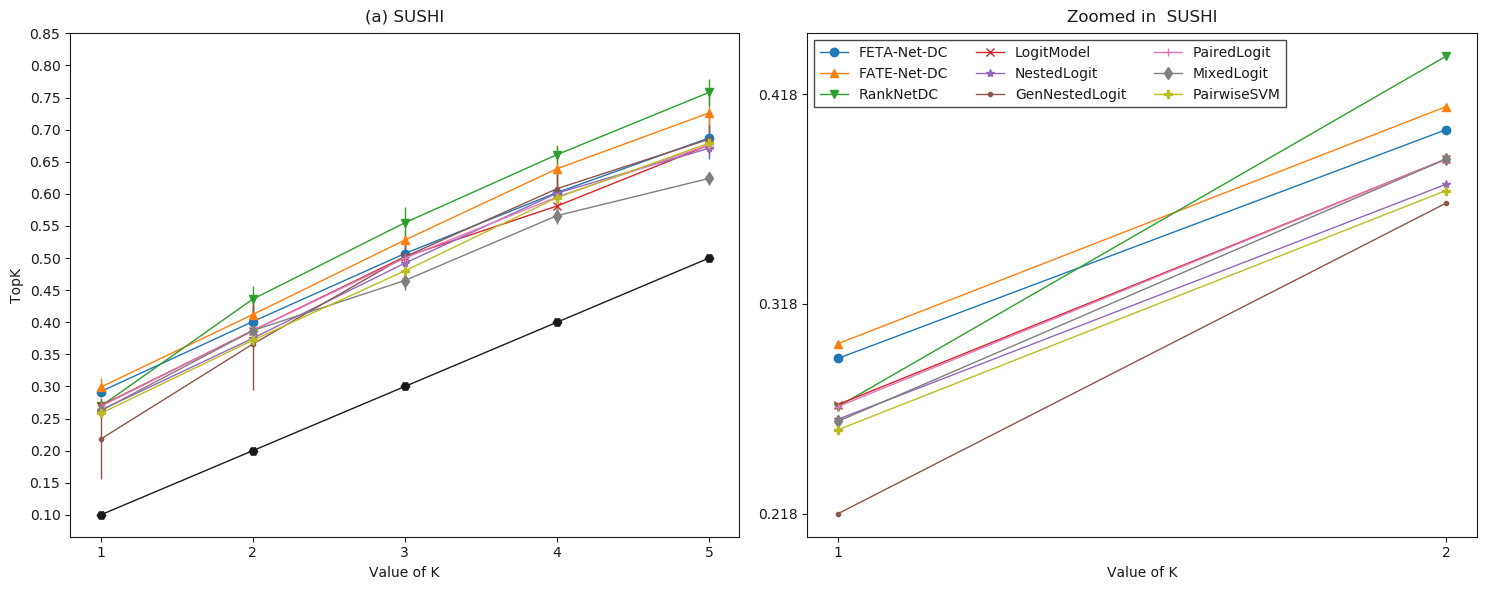

In [16]:
from constants import DCMS
models = ['FETA-Net-DC', 'FATE-Net-DC', 'RankNetDC', 'LogitModel', 'NestedLogit', 'GenNestedLogit', 'PairedLogit', 'MixedLogit', 'PairwiseSVM']
Dlower = [d.upper() for d in DCMS]
models_dict = dict(zip(Dlower, models))
y_label="TopK"
x_label="Value of K"
fig_param = {'facecolor':'w', 'edgecolor':'w', 'transparent':False, 'dpi':800, 'format':'png','bbox_inches':'tight', 'pad_inches':0.05}
anotation = ['(a)', '(b)','(c)','(d)','(e)','(f)','(g)']
for dataset in datasets:
    print(dataset)
    plot_graphs_for_dataset(dataset)

In [8]:
config_file_path = os.path.join(DIR_PATH, 'config', 'clusterdb.json')
schema = 'masterthesis'
self = DBConnector(config_file_path=config_file_path, is_gpu=False, schema=schema)
update_result = "UPDATE results.discrete_choice set cluster_id = %s, CategoricalAccuracy = %s, CategoricalTopK2 = %s, CategoricalTopK3 = %s, CategoricalTopK4 = %s, CategoricalTopK5 = %s, CategoricalTopK6 = %s  where job_id= %s"
values = ('22412', '0.0636', '0.1329', '0.2200', '0.3250', '0.4517', '0.5950', '1002')
self.init_connection()
self.cursor_db.execute(update_result, tuple(values))
self.close_connection()

In [8]:
DATASET = datasets[0]
df_full, columns = get_results_for_dataset(DATASET, del_jid=False)
print(columns)
#df_full['zeroonerankaccuracy'] = 1 - df_full['zeroonerankloss']
df = df_full.loc[df_full.learner.str.contains("NESTED_LOGIT_MODEL")].sort_values(['learner', 'dataset'])
#df = df.loc[df.dataset.str.contains("Y_2008")].sort_values(['learner', 'dataset', 'job_id'])
df

['job_id', 'dataset', 'learner', 'categoricalaccuracy', 'categoricaltopk2', 'categoricaltopk3', 'categoricaltopk4', 'categoricaltopk5', 'categoricaltopk6']


,job_id,dataset,learner,categoricalaccuracy,categoricaltopk2,categoricaltopk3,categoricaltopk4,categoricaltopk5,categoricaltopk6
107,1034,HYPERVOLUME,NESTED_LOGIT_MODEL,0.2911,0.4131,0.5085,0.5798,0.6482,0.7191
106,1032,HYPERVOLUME,NESTED_LOGIT_MODEL,0.2915,0.4207,0.5208,0.5917,0.6588,0.7270
105,1006,HYPERVOLUME,NESTED_LOGIT_MODEL,0.2862,0.4090,0.5027,0.5737,0.6437,0.7170
84,1035,HYPERVOLUME,NESTED_LOGIT_MODEL,0.2915,0.4161,0.5100,0.5814,0.6529,0.7258
83,1033,HYPERVOLUME,NESTED_LOGIT_MODEL,0.2955,0.4199,0.5129,0.5819,0.6501,0.7223
78,1029,MEDOID,NESTED_LOGIT_MODEL,0.0517,0.1514,0.2256,0.3196,0.4315,0.5745
100,1002,MEDOID,NESTED_LOGIT_MODEL,0.0636,0.1329,0.2200,0.3250,0.4517,0.5950
101,1028,MEDOID,NESTED_LOGIT_MODEL,0.0607,0.1314,0.2136,0.3196,0.4471,0.5891
103,1030,MEDOID,NESTED_LOGIT_MODEL,0.0331,0.1056,0.2095,0.3412,0.4898,0.6413
104,1031,MEDOID,NESTED_LOGIT_MODEL,0.0340,0.1076,0.2134,0.3467,0.4924,0.6411


In [21]:
df = create_combined_dfs2(DATASET, latex_row=True)
df.sort_values(by='dataset')
df

,dataset,learner,categoricalaccuracy,categoricaltopk2,categoricaltopk3,categoricaltopk4,categoricaltopk5,categoricaltopk6
0,HYPERVOLUME,GENERALIZED_EXTREME_VALUE,0.293(18),0.369(20),0.472(21),0.567(18),0.663(14),0.756(9)
1,HYPERVOLUME,MIXED_LOGIT_MODEL,0.189(14),0.338(17),0.451(19),0.542(20),0.621(14),0.692(10)
2,HYPERVOLUME,MULTINOMIAL_LOGIT_MODEL,0.201(8),0.267(10),0.360(10),0.456(8),0.559(4),0.664(4)
3,HYPERVOLUME,NESTED_LOGIT_MODEL,0.291(3),0.416(5),0.511(7),0.582(6),0.651(6),0.722(4)
4,HYPERVOLUME,PAIRED_COMBINATORIAL_LOGIT,0.185(1),0.248(1),0.340(2),0.440(2),0.550(2),0.668(2)
5,HYPERVOLUME,RANKSVM_DC,0.186(1),0.248(1),0.340(2),0.439(2),0.550(2),0.667(2)
6,HYPERVOLUME,FETA_DC,0.766(18),0.874(15),0.932(5),0.960(2),0.978(1),0.990(2)
7,HYPERVOLUME,RANKNET_DC,0.203(4),0.276(6),0.369(6),0.462(5),0.562(4),0.665(7)
8,HYPERVOLUME,FATE_DC,0.730(18),0.855(19),0.920(13),0.949(9),0.968(6),0.980(3)
9,MEDOID,GENERALIZED_EXTREME_VALUE,0.020(1),0.085(2),0.195(4),0.338(3),0.500(1),0.661(5)


In [22]:
import re
def remove_ranker(sub_df):
    remove_ranker = None
    if len(sub_df)==2:
        sub_df = sub_df[:,1:3]
        val1 = [float(x) for x in re.findall(r"[-+]?\d*\.\d+|\d+", sub_df[0][1])]
        val2 = [float(x) for x in re.findall(r"[-+]?\d*\.\d+|\d+", sub_df[1][1])]
        val1 = val1[0] if len(val1)==1 else val1[0] - val1[1]*1e-3
        val2 = val2[0] if len(val2)==1 else val2[0] - val2[1]*1e-3
        if val1 < val2 :
            remove_ranker = sub_df[0][0]
        else:
            remove_ranker = sub_df[1][0]
    
    return remove_ranker

In [23]:
def get_val(val):
    vals =  [float(x) for x in re.findall(r"[-+]?\d*\.\d+|\d+", val)]
    return [vals[0], vals[0] - vals[1]*1e-3]
def mark_best(df):
    for col in list(df.columns)[1:]:
        values_str = df[['learner',col]].as_matrix()
        values = np.array([get_val(val[1])for val in values_str])
        maxi = np.where(values[:,0] == values[:,0][np.argmax(values[:,0])])[0]
        for ind in maxi:
            values_str[ind] = [values_str[ind][0], "bfseries {}".format(values_str[ind][1])]
        df['learner'] = values_str[:,0]
        df[col] = values_str[:,1]
    return df

In [24]:
#from tabulate import tabulate
import string
grouped = df.groupby(['dataset'])
for name, group in grouped:
    
    remove_rankers = []
    sub_df = group[group['learner'].str.contains("FETA")].as_matrix()
    r1 = remove_ranker(sub_df)
    sub_df = group[group['learner'].str.contains("FATE")].as_matrix()
    r2 = remove_ranker(sub_df)
    sub_df = group[group['learner'].str.contains("RANKNET")].as_matrix()
    r3 = remove_ranker(sub_df)
    remove_rankers.append(r1)
    remove_rankers.append(r2)
    remove_rankers.append(r3)
    group = group[~group['learner'].isin(remove_rankers)]
    group = group.replace({'FETA_DC_SHALLOW_ZERO': "FETA_DC"})
    group = group.replace({'FATE_DC_SHALLOW': "FATE_DC"})
    group = group.replace({'RANKNET_DC_SHALLOW': "RANKNET_DC"})
    custom_dict = {"RANKSVM_DC":0, "RANKNET_DC":1, 'MULTINOMIAL_LOGIT_MODEL':2, 'NESTED_LOGIT_MODEL':3, 'GENERALIZED_EXTREME_VALUE':4, 
                   'PAIRED_COMBINATORIAL_LOGIT':5, "MIXED_LOGIT_MODEL":6, "FATE_DC":7, "FETA_DC":8, "FETA_DC_ZERO":9}
    group['rank'] = group['learner'].map(custom_dict)
    group.sort_values(by='rank', inplace=True)
    del group["dataset"]
    del group['rank']
    group = mark_best(group)
    if len(group)==9:
        group['learner'] = ["pairwisesvm", "ranknetdc", "mnl", "nlm", "gnl", "pcl", "mlm", "fatedc", "fetadc"]
    print("name {}".format(name))
    group = group.drop(columns='categoricaltopk6')
    if "N_5" in name:
        group = group.drop(columns='categoricaltopk5')
    latex_code = group.to_latex(index = False)
    latex_code = latex_code.replace(' ',"")
    latex_code = latex_code.replace('&'," & ")
    latex_code = str(latex_code)
    for learner in group['learner']:
        latex_code = latex_code.replace(learner, "\\{}".format(learner))
    latex_code = latex_code.replace("bfseries", "\\{} ".format("bfseries"))
    #latex_code = latex_code.replace("0.", ".")

    print(latex_code)
#df.T.to_latex()

name HYPERVOLUME
\begin{tabular}{llllll}
\toprule
learner & categoricalaccuracy & categoricaltopk2 & categoricaltopk3 & categoricaltopk4 & categoricaltopk5\\
\midrule
\pairwisesvm & 0.186(1) & 0.248(1) & 0.340(2) & 0.439(2) & 0.550(2)\\
\ranknetdc & 0.203(4) & 0.276(6) & 0.369(6) & 0.462(5) & 0.562(4)\\
\mnl & 0.201(8) & 0.267(10) & 0.360(10) & 0.456(8) & 0.559(4)\\
\nlm & 0.291(3) & 0.416(5) & 0.511(7) & 0.582(6) & 0.651(6)\\
\gnl & 0.293(18) & 0.369(20) & 0.472(21) & 0.567(18) & 0.663(14)\\
\pcl & 0.185(1) & 0.248(1) & 0.340(2) & 0.440(2) & 0.550(2)\\
\mlm & 0.189(14) & 0.338(17) & 0.451(19) & 0.542(20) & 0.621(14)\\
\fatedc & 0.730(18) & 0.855(19) & 0.920(13) & 0.949(9) & 0.968(6)\\
\fetadc & \bfseries 0.766(18) & \bfseries 0.874(15) & \bfseries 0.932(5) & \bfseries 0.960(2) & \bfseries 0.978(1)\\
\bottomrule
\end{tabular}

name MEDOID
\begin{tabular}{llllll}
\toprule
learner & categoricalaccuracy & categoricaltopk2 & categoricaltopk3 & categoricaltopk4 & categoricaltopk5\\
\midrule

In [ ]:
df_path = os.path.join(DIR_PATH, 'results' , "discrete_choice.csv")

if not os.path.isfile(df_path):
    dataFrame = df
else:
    dataFrame = pd.read_csv(df_path, index_col=0)
    dataFrame = dataFrame.append(df, ignore_index=True)
dataFrame
dataFrame.to_csv(df_path)

In [ ]:
grouped = df.groupby(['dataset'])
for name, group in grouped:
    df_path = os.path.join(DIR_PATH, 'results' , name.lower()+'.csv')
    group.to_csv(df_path)

In [ ]:
import numpy as np
np.arange(48,87)

X_train = np.arange(40).reshape(4,5,2)

learner_params = {}
learner_params['n_objects'], learner_params['n_object_features'] = X_train.shape[1:]

In [ ]:
"UNIQUE_MAX_OCCURRING".lower()